Treatment effect (raw): 50.33862653226549
Treatment effect (CUPED-adjusted): 53.88349948513701


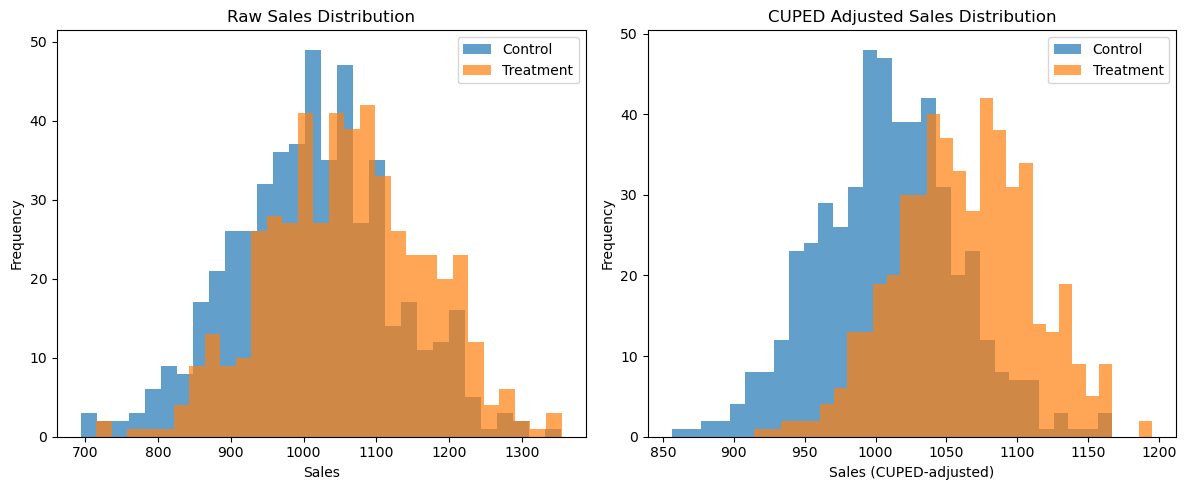

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
────────────(E[sales_cuped|baseline_sales])
d[treatment]                               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→sales_cuped then P(sales_cuped|treatment,baseline_sales,U) = P(sales_cuped|treatment,baseline_sales)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
DoWhy Causal Estimate (CUPED-adjusted outcome):
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
────────────(E[sales_cuped|baseline_

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dowhy import CausalModel

# Set random seed for reproducibility
np.random.seed(42)

# -----------------------------
# 1. Simulate a Retail Dataset
# -----------------------------
n = 1000  # number of observations (e.g., retail stores)

# Create a DataFrame with simulated data
df = pd.DataFrame()

# Unique store id
df['store_id'] = np.arange(1, n + 1)

# Assign treatment randomly (e.g., stores receiving a new marketing strategy)
df['treatment'] = np.random.binomial(1, 0.5, size=n)

# Simulate a pre-experiment covariate: baseline_sales
# This could be last month’s average sales per store
df['baseline_sales'] = np.random.normal(loc=1000, scale=100, size=n)

# -----------------------------
# 2. Simulate the Outcome Variable
# -----------------------------
# Assume that the sales outcome is influenced by baseline_sales,
# a fixed treatment effect, and some random noise.
effect_size = 50  # additional sales due to treatment
noise = np.random.normal(0, 50, size=n)

# Sales is the post-treatment outcome, constructed as:
# sales = baseline_sales + (treatment * effect_size) + noise
df['sales'] = df['baseline_sales'] + df['treatment'] * effect_size + noise

# -----------------------------
# 3. Apply the CUPED Method
# -----------------------------
# CUPED uses a pre-experiment covariate (baseline_sales) to reduce variance.
# Step 3a: Compute the covariance between sales and baseline_sales in the control group.
control_group = df[df['treatment'] == 0]
theta = np.cov(control_group['sales'], control_group['baseline_sales'])[0, 1] / \
        np.var(control_group['baseline_sales'])

# Step 3b: Compute the overall mean of baseline_sales across all observations.
mean_baseline = df['baseline_sales'].mean()

# Step 3c: Calculate the adjusted outcome (sales_cuped) using the CUPED formula:
# sales_cuped = sales - theta * (baseline_sales - mean_baseline)
df['sales_cuped'] = df['sales'] - theta * (df['baseline_sales'] - mean_baseline)

# -----------------------------
# 4. Compare Treatment Effects Before and After CUPED Adjustment
# -----------------------------
# Calculate the average sales for treatment and control groups without adjustment
avg_sales_control = df.loc[df['treatment'] == 0, 'sales'].mean()
avg_sales_treatment = df.loc[df['treatment'] == 1, 'sales'].mean()
raw_effect = avg_sales_treatment - avg_sales_control

# Calculate the average adjusted sales for treatment and control groups (CUPED)
avg_cuped_control = df.loc[df['treatment'] == 0, 'sales_cuped'].mean()
avg_cuped_treatment = df.loc[df['treatment'] == 1, 'sales_cuped'].mean()
cuped_effect = avg_cuped_treatment - avg_cuped_control

# Display the results
print("Treatment effect (raw):", raw_effect)
print("Treatment effect (CUPED-adjusted):", cuped_effect)

# Optional: Visualize the distributions to see the variance reduction
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df.loc[df['treatment'] == 0, 'sales'], bins=30, alpha=0.7, label='Control')
plt.hist(df.loc[df['treatment'] == 1, 'sales'], bins=30, alpha=0.7, label='Treatment')
plt.title("Raw Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df.loc[df['treatment'] == 0, 'sales_cuped'], bins=30, alpha=0.7, label='Control')
plt.hist(df.loc[df['treatment'] == 1, 'sales_cuped'], bins=30, alpha=0.7, label='Treatment')
plt.title("CUPED Adjusted Sales Distribution")
plt.xlabel("Sales (CUPED-adjusted)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# 5. Use DoWhy for Causal Inference with CUPED-Adjusted Outcome
# -----------------------------
# Define the causal model.
# Here the treatment is 'treatment', the outcome is the CUPED-adjusted sales,
# and we include the baseline_sales as a common cause.
model = CausalModel(
    data=df,
    treatment='treatment',
    outcome='sales_cuped',
    common_causes=['baseline_sales']
)

# Identify the causal effect using DoWhy's identification methods.
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimate the causal effect using a linear regression adjustment.
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")
print("DoWhy Causal Estimate (CUPED-adjusted outcome):")
print(causal_estimate)

# Optionally, you can refute the estimate using random placebo treatment assignment.
refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print(refutation)


In [ ]:
effect_size_cuped

In [ ]:
effect_size_raw

In [3]:
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind


# -----------------------------
# 6. Power Analysis: Calculate Required Sample Sizes
# -----------------------------
# Set power analysis parameters:
alpha = 0.05  # significance level
desired_power = 0.95  # desired statistical power

# For the CUPED-adjusted scenario:
effect_size_cuped = effect_size / np.std(df['sales_cuped'])  # standardized effect size
analysis = TTestIndPower()
sample_size_cuped = analysis.solve_power(effect_size=effect_size_cuped, alpha=alpha, power=desired_power, alternative='two-sided')

# For the raw sales scenario:
effect_size_raw = effect_size / np.std(df['sales'])  # standardized effect size for raw outcome
sample_size_raw = analysis.solve_power(effect_size=effect_size_raw, alpha=alpha, power=desired_power, alternative='two-sided')

# Print the sample sizes required in each scenario
print("Required sample size (CUPED-adjusted):", sample_size_cuped)
print("Required sample size (raw sales):", sample_size_raw)

# -----------------------------
# 7. Statistical Significance Testing (t-tests)
# -----------------------------
# T-test on raw sales to compare treatment and control groups
control_sales = df.loc[df['treatment'] == 0, 'sales']
treatment_sales = df.loc[df['treatment'] == 1, 'sales']
t_stat_raw, p_value_raw = ttest_ind(treatment_sales, control_sales, equal_var=False)

# T-test on CUPED-adjusted sales
control_sales_cuped = df.loc[df['treatment'] == 0, 'sales_cuped']
treatment_sales_cuped = df.loc[df['treatment'] == 1, 'sales_cuped']
t_stat_cuped, p_value_cuped = ttest_ind(treatment_sales_cuped, control_sales_cuped, equal_var=False)

# Print the t-test results for both scenarios
print("\nT-test results (raw sales):")
print("t-statistic:", t_stat_raw)
print("p-value:", p_value_raw)

print("\nT-test results (CUPED-adjusted sales):")
print("t-statistic:", t_stat_cuped)
print("p-value:", p_value_cuped)

Required sample size (CUPED-adjusted): 33.01575116909606
Required sample size (raw sales): 131.65842812551904

T-test results (raw sales):
t-statistic: 7.278066065283456
p-value: 6.851040732576229e-13

T-test results (CUPED-adjusted sales):
t-statistic: 17.545448161369084
p-value: 2.907522258546261e-60


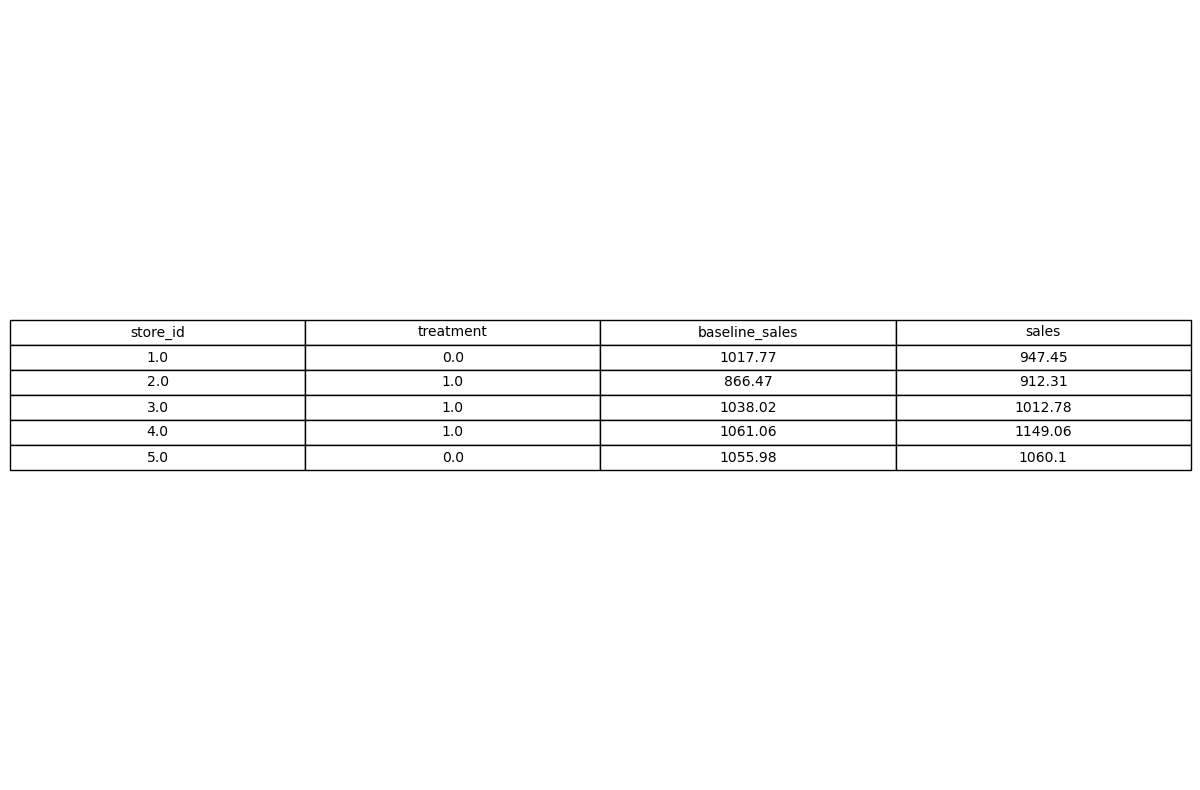

In [5]:
fig, ax = plt.subplots(figsize=(12,8)) #Adjust figure size to fit the screen

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

# Round the values to 2 decimal places
cell_text = np.round(df.drop(columns='sales_cuped').head().values, 2)

# Create the table
table = ax.table(cellText=cell_text, colLabels=df.drop(columns='sales_cuped').head().columns, loc='center')

# Modify cells to center the text
for (row, col), cell in table.get_celld().items():
    if row > 0:  # Exclude header row
        cell.set_text_props(ha='center', va='center')

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust font size if needed
table.scale(1.2, 1.2)  # Adjust the table size

fig.tight_layout()

plt.show()